In [1]:
import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import scipy.stats as stats
import utils

# Clean Traffic Data

In [2]:
year = 2019
path = f'../nyc_speed_data/*{year}.csv'

df = utils.load_csv(path)

 42%|████▏     | 5/12 [00:08<00:11,  1.64s/it]/home/smr1020/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (0,1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
100%|██████████| 12/12 [00:26<00:00,  2.23s/it]


In [3]:
df = df.dropna()
df['DataAsOf'] = pd.to_datetime(df['DataAsOf'])

In [4]:
df['Speed_norm'] = 0
for group in df.groupby('Id'):
    df_tem = group[1]
    df_tem['Speed_norm'] = stats.zscore(df_tem['Speed'])
    df['Speed_norm'][df.index.isin(df_tem.index)] = df_tem['Speed_norm']

<ipython-input-4-a9b855d8c37e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tem['Speed_norm'] = stats.zscore(df_tem['Speed'])
<ipython-input-4-a9b855d8c37e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Speed_norm'][df.index.isin(df_tem.index)] = df_tem['Speed_norm']
<ipython-input-4-a9b855d8c37e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [5]:
df.to_csv(f'traffic_data_clean_{year}.csv')

In [6]:
df = pd.read_csv(f'traffic_data_clean_{year}.csv')
df['DataAsOf'] = pd.to_datetime(df['DataAsOf'])
df = df[['Id','Speed_norm','DataAsOf']]
df.head()

,Id,Speed_norm,DataAsOf
0,1,0.379229,2019-04-01 02:58:11
1,106,-0.883832,2019-04-01 02:58:11
2,110,0.415683,2019-04-01 02:58:04
3,119,-2.081642,2019-04-01 02:58:03
4,124,0.647066,2019-04-01 02:58:03


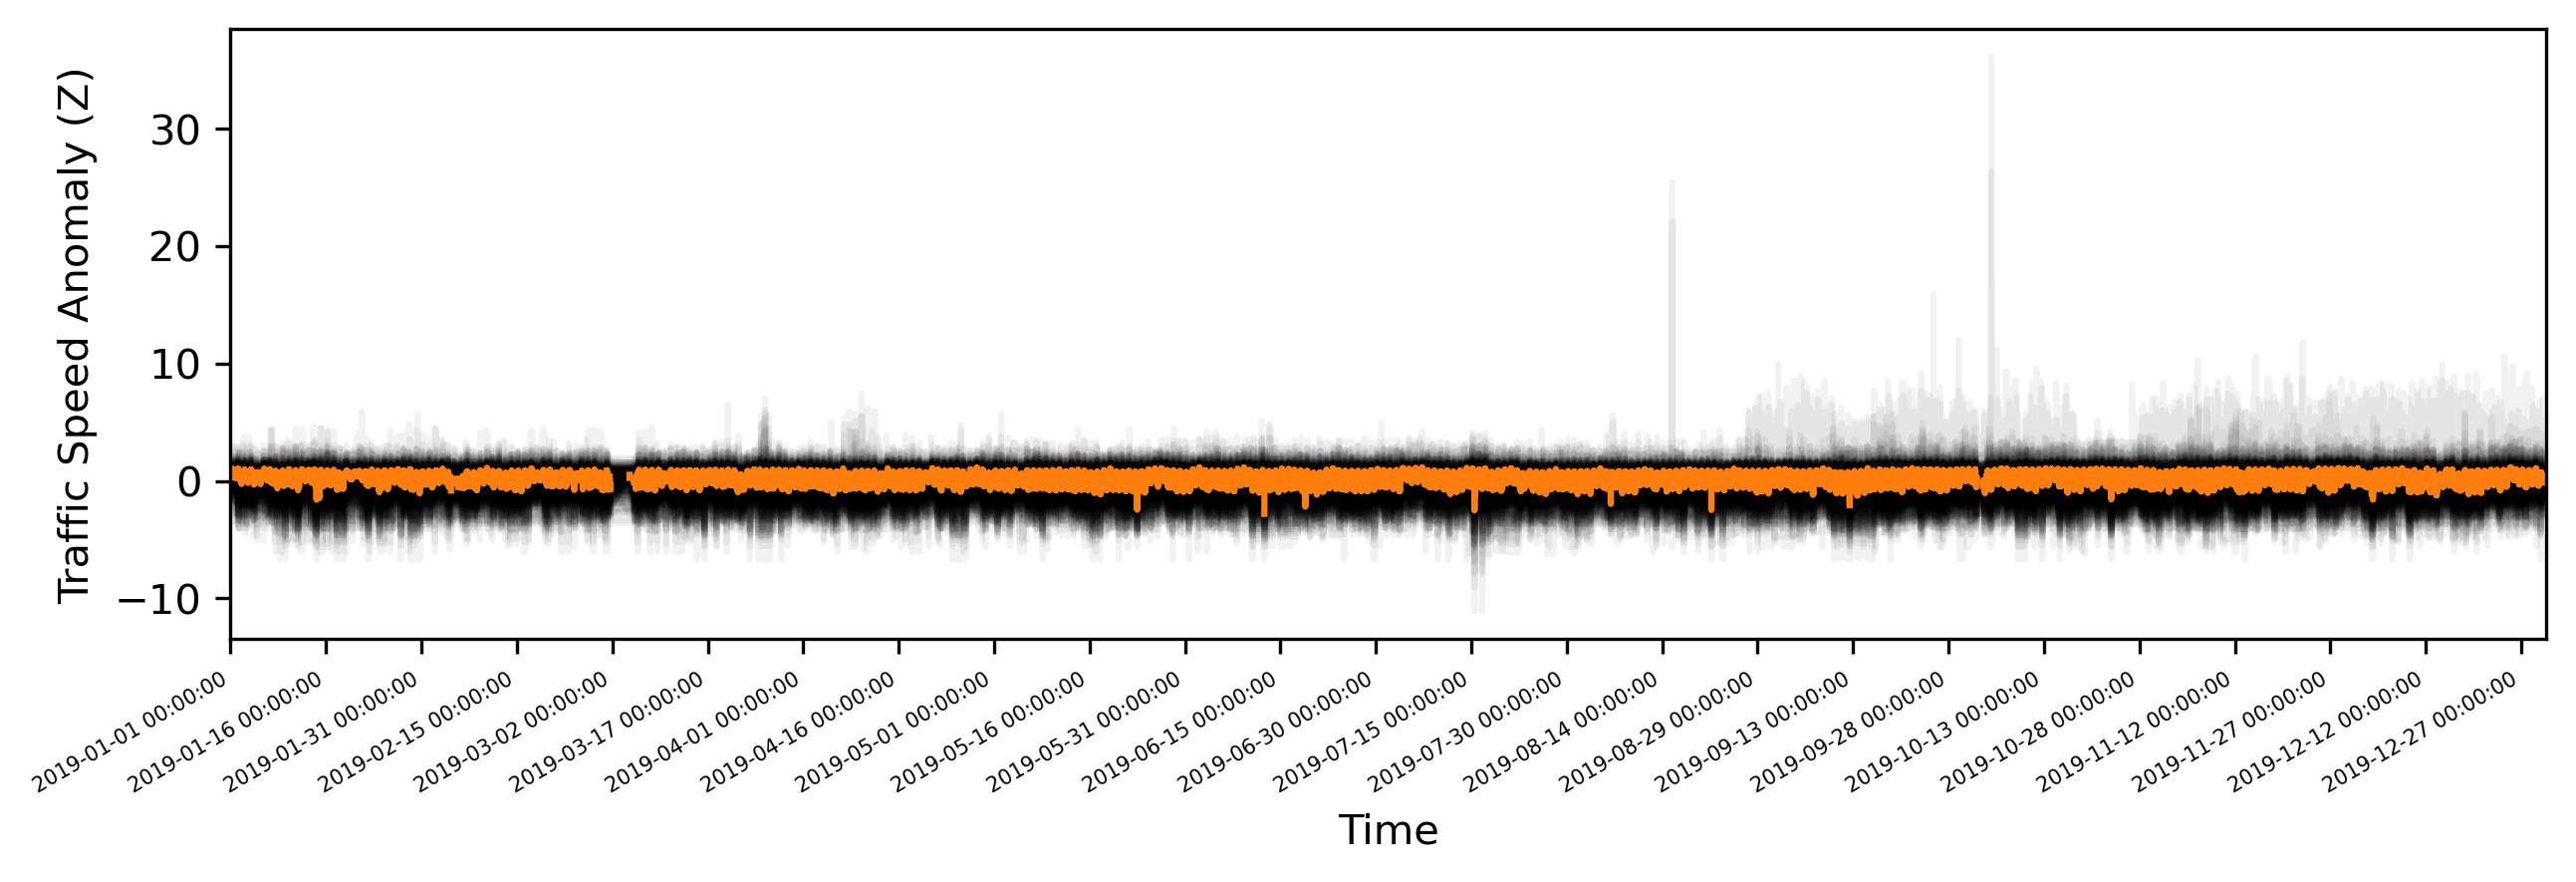

In [7]:
start = f'{year}-01-01'
end = f'{year}-12-31'

df_rs = utils.plot_traffic_speed(df,start,end,figsize = (10,3),ticks='15D')

### Remove days where we have less than 80% of sensors working 
If too many sensors are down, the median response won't represent the whole city

In [8]:
sensor_outage = df_rs.isna().sum(axis=1)
tol = 28

cond_keep = sensor_outage<tol
cond_toss = sensor_outage>tol

speed_ts = df_rs.median(axis=1)

speed_ts[cond_toss] = np.nan

### Visualize removal of days with 20% of sensors malfunctioning

In [9]:
# plt.figure(figsize = (400,3))
# df_rs.isna().sum(axis=1).plot(xlim=('2019-01-01','2019-12-31'))
# plt.scatter(df_rs.isna().sum(axis=1)[cond_toss].index,
#             df_rs.isna().sum(axis=1)[cond_toss],c='r',zorder=20)

In [10]:
# plt.figure(figsize = (400,3))
# df_rs.median(axis=1)[cond_keep].plot(xlim=('2019-01-01','2019-12-31'))

# plt.scatter(df_rs.median(axis=1)[cond_toss].index,
#             df_rs.median(axis=1)[cond_toss],c='r')

### A normal day

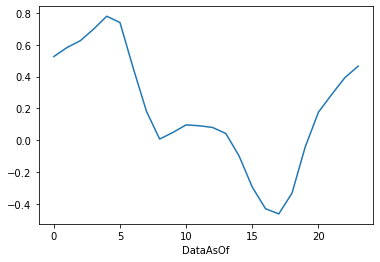

In [11]:
speed_ts.groupby(df_rs.index.hour).mean().plot()

# Clean Weather Data

download weather data via api request

In [12]:
baseurl='https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?'

request = f'station=NYC\
&data=tmpf&data=dwpf&data=p01i&data=wxcodes\
&year1={year}&month1=1&day1=1&year2={year}&month2=12&day2=31&tz=Etc%2FUTC\
&format=onlycomma&latlon=no&missing=M&trace=T&direct=no&report_type=1&report_type=2'

df_weather = pd.read_csv(f'{baseurl}{request}',na_values=['M'])

In [13]:
# small amounts of precip are marked at T (trace)
df_weather['p01i'][df_weather['p01i'] == 'T'] = 0.001
df_weather['p01i'] = df_weather['p01i'].astype(float)

# set datetime index and make sure only these columns are in the data ['time','tmpf','dwpf','p01i']
df_weather['time'] = pd.to_datetime(df_weather['valid'])
df_weather = df_weather[['time','p01i','wxcodes']]
df_weather['time'] = df_weather['time'] - pd.to_timedelta('1H')
df_weather = df_weather.set_index('time')

#drop na values
df_weather = df_weather.dropna()

<ipython-input-13-2a856e4f1330>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather['p01i'][df_weather['p01i'] == 'T'] = 0.001


# Make snow feature
snow is encoded as a categorical variable (it's hard for these weather stations to measure automatically)

In [14]:
df_weather['wxcodes'].str.contains('SN').dropna().astype(int).sum()

253

In [15]:
df_weather['wxcodes'].str.contains('\-SN').dropna().astype(int).sum()

225

In [16]:
df_weather['wxcodes'].str.contains('\+SN').dropna().astype(int).sum()

5

In [17]:
((df_weather['wxcodes'].str.contains('\SN')) & ~(df_weather['wxcodes'].str.contains('\-SN')) & ~(df_weather['wxcodes'].str.contains('\+SN'))).sum()

23

In [18]:
df_weather = df_weather.dropna()
df_weather['snow'] = 0
df_weather['snow'][df_weather['wxcodes'].str.contains('\-SN')] = 1
df_weather['snow'][(df_weather['wxcodes'].str.contains('\SN'))
                   & ~(df_weather['wxcodes'].str.contains('\-SN'))
                   & ~(df_weather['wxcodes'].str.contains('\+SN'))] = 2
df_weather['snow'][df_weather['wxcodes'].str.contains('\+SN')] = 3


df_weather['rain'] = 0
df_weather['rain'][df_weather['wxcodes'].str.contains('\-RN')] = 1
df_weather['rain'][(df_weather['wxcodes'].str.contains('\RN'))
                   & ~(df_weather['wxcodes'].str.contains('\-RN'))
                   & ~(df_weather['wxcodes'].str.contains('\+RN'))] = 2
df_weather['rain'][df_weather['wxcodes'].str.contains('\+RN')] = 3

df_weather = df_weather.drop('wxcodes',axis=1)

<ipython-input-18-80abd6a6c415>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather['snow'][df_weather['wxcodes'].str.contains('\-SN')] = 1
<ipython-input-18-80abd6a6c415>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather['snow'][(df_weather['wxcodes'].str.contains('\SN'))
<ipython-input-18-80abd6a6c415>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather['snow'][df_weather['wxcodes'].str.contains('\+SN')] = 3

In [19]:
df_weather = df_weather.resample('5min').pad()

In [20]:
df_weather.head()

,p01i,snow
time,,
2018-12-31 23:10:00,0.04,0
2018-12-31 23:15:00,0.04,0
2018-12-31 23:20:00,0.04,0
2018-12-31 23:25:00,0.04,0
2018-12-31 23:30:00,0.04,0


# Merge Weather and Traffic Data

In [21]:
df_norm = df_weather
df_norm['speed'] = speed_ts
df_norm = df_norm[df_norm.index.isin(speed_ts.index)]

In [22]:
df_norm.index.hour

Int64Index([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
            ...
            13, 13, 13, 13, 13, 13, 13, 13, 13, 13],
           dtype='int64', name='time', length=104687)

In [23]:
 df_norm.mean()

p01i     0.017035
snow     0.065042
speed    0.189534
dtype: float64

In [24]:
# means = df_norm.mean()
# stds = df_norm.std()


df_norm['speed'] = (df_norm['speed'] - 0.181692)/0.461967

dhour = (df_norm.index.hour.values+df_norm.index.minute.values/60)

# normalize using sin
# df_norm['month'] = np.sin((df_norm.index.month/df_norm.index.month.max())*2*np.pi)
df_norm['weekday'] = (df_norm.index.dayofweek < 5).astype(int)
df_norm['hour'] = np.sin((dhour/24)*2*np.pi)

df_norm['p01i'] = ((df_weather['p01i'])**(1/3))*2 # cubic normalization for these data
df_norm['snow'] = df_weather['snow'] # no additional norm for these data

<ipython-input-24-b345d59d76a6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_norm['speed'] = (df_norm['speed'] - 0.181692)/0.461967
<ipython-input-24-b345d59d76a6>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_norm['weekday'] = (df_norm.index.dayofweek < 5).astype(int)
<ipython-input-24-b345d59d76a6>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

In [25]:
cond = df_norm['speed'].isna()

In [26]:
df_norm = df_norm.interpolate(method='linear',limit=12)
noise = np.random.normal(1,0.08,cond.sum())
df_norm['speed'][cond]=df_norm['speed'][cond]*noise
# df_norm['speed'].plot(xlim=('2019-07-15 10:00','2019-07-15 14:00'))

<ipython-input-26-f37d80113c9e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_norm['speed'][cond]=df_norm['speed'][cond]*noise


In [27]:
week_days = df_norm[df_norm.index.dayofweek < 5]
week_ends = df_norm[df_norm.index.dayofweek > 4]

In [28]:
normal_wd = week_days.groupby(week_days.index.hour).mean()
normal_we = week_ends.groupby(week_ends.index.hour).mean()
normal_wd['snow'] = 0
normal_wd['p01i'] = 0
normal_we['snow'] = 0
normal_we['p01i'] = 0

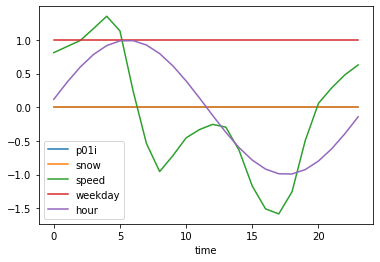

In [29]:
normal_wd.plot()

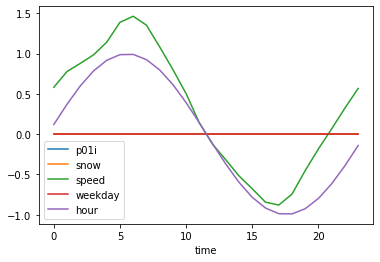

In [30]:
normal_we.plot()

In [31]:
df_copy = df_norm
count = 0

for group in df_copy.groupby(df_copy.index.dayofyear):
    
    n_na = group[1]['speed'].isna().sum().max()
    
    if n_na > 1:
        
        if group[1].index.dayofweek[1] > 4:
        
            copy = group[1].resample('1H').mean()
            copy = normal_we.set_index(copy.index)
            copy = copy.resample('5min').interpolate('cubic')

            noise = np.random.normal(1,0.08,len(copy['speed']))
            copy['speed'] = copy['speed']*noise
            
        if group[1].index.dayofweek[1] < 5:
            
            start = group[1].resample('1H').mean().index[0]
            copy = normal_wd.set_index(pd.date_range(start=start,freq='1H',periods=24))
            copy = copy.resample('5min').interpolate('cubic')

            noise = np.random.normal(1,0.08,len(copy['speed']))
            copy['speed'] = copy['speed']*noise
            
        df_norm[df_norm.index.isin(copy.index)] = copy
        
        count += 1

In [32]:
print(count)

33


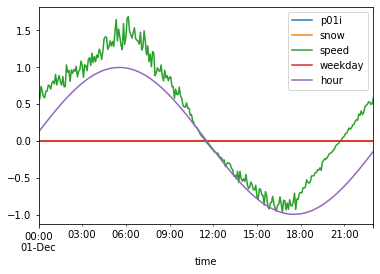

In [33]:
copy.plot()

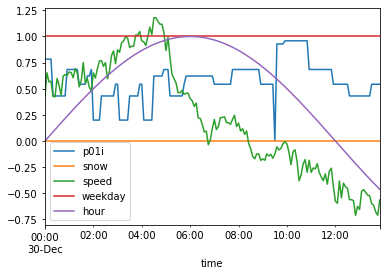

In [34]:
group[1].plot()

In [35]:
# df_norm['speed'].plot(xlim=('2019-03-01','2019-03-06'))
# # plt.axvline('2019-03-02',c='r')

In [36]:
# df_norm['speed'].interpolate('linear').plot(xlim=('2019-03-01','2019-03-06'))

In [37]:
df_norm = df_norm.interpolate('linear')

In [38]:
df_norm.to_csv(f'df_norm_{year}.csv')

In [39]:
df_norm.head()

,p01i,snow,speed,weekday,hour
time,,,,,
2019-01-01 02:00:00,1.207362,0.0,0.297916,1.0,0.500000
2019-01-01 02:05:00,1.207362,0.0,0.279834,1.0,0.518773
2019-01-01 02:10:00,1.207362,0.0,0.316886,1.0,0.537300
2019-01-01 02:15:00,1.207362,0.0,0.353860,1.0,0.555570
2019-01-01 02:20:00,1.207362,0.0,0.316886,1.0,0.573576
